In [2]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import TwoSlopeNorm
import cmocean as cm

## The model

Consider the following modification to the heat equation:

$$
\frac{\partial T}{\partial t} = \frac{\partial}{\partial z} \bigg(\kappa \frac{\partial T}{\partial z}\bigg) + \bigg(\frac{Q(t)}{\rho_0 c_p z_m} - \gamma\big(T - (T_i(z) + T_0(t))\big) \bigg) \times H(z_m - z) - \mu \big(T - T_i(z) \big) \times H(z - z_d) + \text{C.A.},$$ 

where $T = T(t, z)$ is the temperature (MAKE A NOTE OF WHETHER WE THINK OF THIS AS POTENTIAL, CONSERVATIVE, IN SITU, ETC.); $\kappa$ is the (constant) diffusivity; $Q(t)$ is a prescribed, time-dependent surface heat flux; $\rho_0 = 1025$ kg m$^{-3}$ is the reference density; $c_p = 4000$ J/(kg C) is the specific heat capacity; $z_m$ is the depth of the mix*ing* layer (i.e., a minimum mixed layer); $\gamma$ is a damping term (acting like a climate feedback parameter) which acts to restore the surface back to some initial state $T_i(z)$. The term $T_0$ is applied in perturbations to perturb the surface temperature (like an air temperature perturbation). The $H$ represents a Heaviside function to denote that this forcing and restoring is applied over the minimum mixing layer. The next term is a deep ocean restoring term which acts to balance the surface restoring at the surface. This is so that the steady-state solution is not simply a profile of constant temperature equal to the surface temperature. The paramater $\mu$ is a characteristic timescale over which the temperature profile is relaxed back to its initial profile $T_i(z)$ in the deep ocean (e.g., 20 years), applied only below some prescribed depth $z_d$ (e.g., $z_d = 900$m).

Finally, the term 'C.A.' denotes a convective adjustment algorithm, following _Rahmstorf (1993)_, which checks at each timestep whether any convective instabilities arise and removes them conservatively.

_Make a note of the initial and boundary conditions._

We will write a forward-time, central-space finite difference scheme for this initial-boundary value problem. I have also solved analytically for the steady-state solution, which can be found in an Appendeix to the thesis.

In [75]:
# Constants, data, parameters...

rho = 1035 # kg/m^3
c = 4000 # J/(kg C)

z_m = 25.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-06
mu = 1/(10 * 365 * 86400)

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 2.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell


# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz/2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)


# # Initial condition: replicating the globally-averaged annually-averaged profile in the ACCESS control simulation. Sliced between 66.5 S and 66.5 N.
# # cf. notebook: ACCESS_temperature_profile.ipynb

# T_access = np.array([18.72962875, 18.71776308, 18.69791137, 18.65953715, 18.59233366,
#         18.4877693 , 18.32777701, 18.10955722, 17.83265471, 17.50359963,
#         17.12776242, 16.69579974, 16.17275077, 15.51015988, 14.64561039,
#         13.68938628, 12.81617282, 12.06698519, 11.35341532, 10.651462  ,
#          9.91621954,  9.17371283,  8.47307245,  7.79774866,  7.11181125,
#          6.39582611,  5.69181462,  5.00613208,  4.34195891])
# z_access = np.array([1.15174985,    3.64867401,    6.56491852,    9.97086906,
#           13.94870853,   18.59437943,   24.01987267,   30.35588455,
#           37.75489044,   46.39470291,   56.48257065,   68.25986481,
#           82.00740814,   98.0514679 ,  116.7703476 ,  138.60160828,
#          164.04943848,  193.69206238,  228.18814087,  268.28121948,
#          314.8001709 ,  368.65353394,  430.81393433,  502.28930664,
#          584.0770874 ,  677.10028076,  782.12670898,  899.6817627 ,
#         1029.96813965])

# def linear_interpol(T_old, z_old, z_new):
#     T_new = np.full_like(z_t, 0)
    
#     j = 0
#     for i in range(len(z_new)):
#         if z_new[i] < z_old[j + 1]:
#             T_new[i] = T_old[j] + (T_old[j + 1] - T_old[j]) / (z_old[j + 1] - z_old[j]) * (z_new[i] - z_old[j])
#         else:
#             j += 1
#             T_new[i] = T_old[j] + (T_old[j + 1] - T_old[j]) / (z_old[j + 1] - z_old[j]) * (z_new[i] - z_old[j])
#     return T_new

# T_i = linear_interpol(T_access, z_access, z_t)

# plt.figure(figsize=(11,11))
# plt.plot(linear_interpol(T_access, z_access, z_t), z_t, label='ACCESS control')
# plt.plot(initial_condition(z_t), z_t, label='Linear stratification')
# plt.title('Globally-averaged, annually-averaged temperature profile between 66.5 S and 66.5 N in ACCESS-OM2 control vs. linear stratification')
# plt.xlabel('Temperature (deg C)')
# plt.ylabel('Depth (m)')
# plt.gca().invert_yaxis()
# plt.legend()

# Analytical steady state, cf. Appendix 1

def steady_state(Z):
    
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # Coefficients
    a_1 = (A * E + B * F) / (A * D - C * F)
    
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # Piecewise defined function (ie, need to use vectorise):
    if Z <= z_m:
        
        return T_0 + a_1 * (np.exp(Z * np.sqrt(gamma / kappa)) + np.exp( - Z * np.sqrt(gamma / kappa)))
    
    elif Z > z_m and Z < z_d:
        
        return T_0 + a_1 * (np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (Z - z_m) \
                            + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    else:
        
        return ((T_0 - T_b) * Z + z_m * T_b - z_b * T_0) / (z_m - z_b) \
    + c_1 * (1 + np.exp(2 * (z_b - Z) * np.sqrt(mu / kappa))) * np.exp(Z * np.sqrt(mu / kappa)) \
    + np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b) * np.exp((z_b - Z) * np.sqrt(mu / kappa))
    
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)


### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### Ocean heat content

def OHC(T):
    
    OHC = np.empty(T.shape[1])
    
    for i in range(len(OHC)):
        
        #OHC[i] = rho * c * np.cumsum(T[: , i])[- 1] * dz # This is for ocean heat content
        
        OHC[i] = np.mean(T[:, i]) # This is for average temperature
        
    return OHC 




### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, lambd, T_initial, Q, T0, years):
    
    # Data
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top/bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top/bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1) # 1 below z = z_d, 0 elsewhere
    Hmix = np.heaviside(z_m - z, 0) # 1 above z = z_m, 0 elsewhere
    radiative_forcing = Q / (c * rho * z_m)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    T = np.zeros((M, N + 1)) # i.e. evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e. evaluated at the top/bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    for n in range(0, N):
    
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            #NB: T_i = T_i(z), the initial profile
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T_i[m]))) * Hmix[m]  \
            - dt * mu * (T[m, n] - T_i[m]) * Hdeep[m]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], z_m)
        
    return T

### Define forcings

In [76]:
years = 100
days = dt / 86400
M = int(z_b / dz)
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

def sin(amp, period):
    period_day = period * 360
    return amp * np.sin((2 * np.pi / period_day) * t)

def rolling_mean(array, period):
    window_size = int(period * 360 / (dt / 86400)
                      
    i = 0
    moving_averages = []
    while i < len(array) - window_size + 1:
        this_window = array[i : i + window_size]

        window_average = np.mean(this_window)
        moving_averages.append(window_average)
        i += 1
                      
    return np.array(moving_averages)

### Run model

In [77]:
years = 100
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-06
mu = 1/(10 * 365 * 86400)

# Control

Q_cont = np.zeros(int(years * 360 / days) + 1)
T0_cont = np.zeros(int(years * 360 / days) + 1)
T_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_cont, T0_cont, years)

# Variable forcing

periods = np.concatenate((np.arange(0.5, 1, 0.1), np.linspace(1,50,50)))
Q = 8
T0 = 1.0

T_sinusoids = np.zeros(shape = (M, N+1, periods.shape[0]))
for p in range(len(periods)):
    T_sinusoids[:, :, p] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, sin(Q, periods[p]), sin(T0, periods[p]), years)
    
T_x2_sinusoids = np.zeros(shape = (M, N+1, periods.shape[0]))
for p in range(len(periods)):
    T_x2_sinusoids[:, :, p] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, sin(2 * Q, periods[p]), sin(2 * T0, periods[p]), years)

T_x3_sinusoids = np.zeros(shape = (M, N+1, periods.shape[0]))
for p in range(len(periods)):
    T_x3_sinusoids[:, :, p] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, sin(3 * Q, periods[p]), sin(3 * T0, periods[p]), years)

In [87]:
def final_temp_distribution(periodic_temps):
    return np.array([rolling_mean(OHC(periodic_temps[:,:,i] - T_cont), periods[i])[-1] for i in range(len(periods))])

T_final_distribution = final_temp_distribution(T_sinusoids)
T_x2_final_distribution = final_temp_distribution(T_x2_sinusoids)
T_x3_final_distribution = final_temp_distribution(T_x3_sinusoids)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


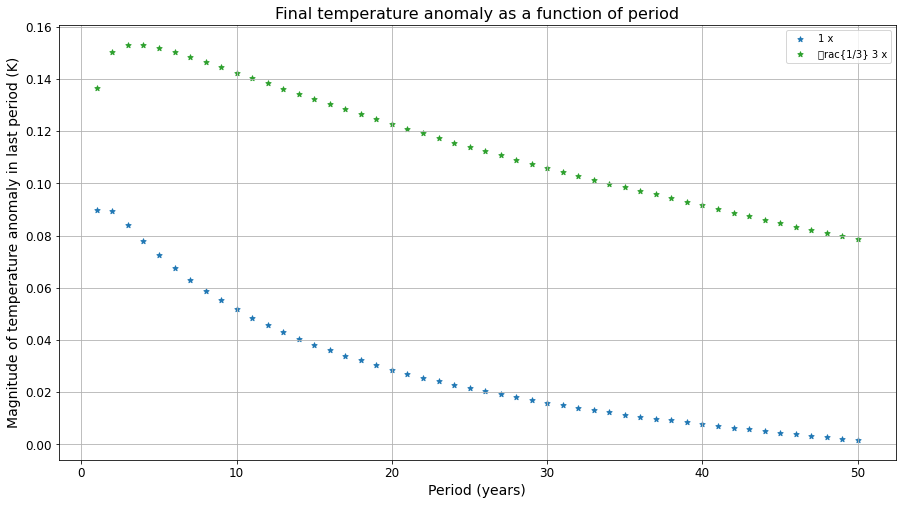

In [145]:
plt.figure(figsize=(15,8))
plt.title('Final temperature anomaly as a function of period', fontsize=16)
plt.xlabel('Period (years)', fontsize=14)
plt.ylabel('Magnitude of temperature anomaly in last period (K)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.scatter(periods, np.abs(T_final_distribution), s=30, marker='*', color='C0', label='1 x')
# plt.scatter(periods, 1/2 * np.abs(T_x2_final_distribution), s=30, marker='*', color='C1', label='2 x')
plt.scatter(periods, 1/3 * np.abs(T_x3_final_distribution), s=30, marker='*', color='C2', label='\frac{1/3} 3 x')
plt.grid()
plt.legend()
# plt.savefig('period_amplitude_final_temp_distribution_.jpg')

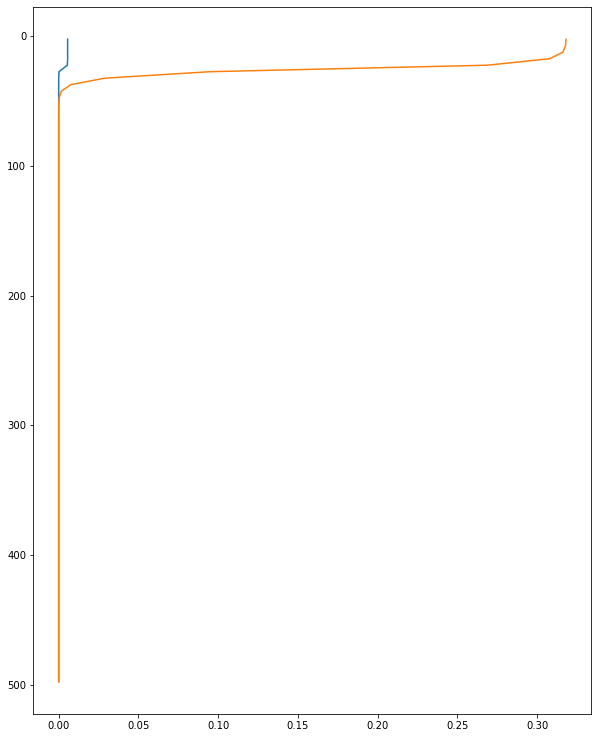

In [383]:
plt.figure(figsize=(10,13))
time=5
depth = 500
plt.plot(T_x3_sinusoids[:int(depth/dz),time,18] - T_cont[:int(depth/dz),time], z_t[:int(depth/dz)])
plt.plot(T_x3_sinusoids[:int(depth/dz),10*time,18] - T_cont[:int(depth/dz),10*time], z_t[:int(depth/dz)])
plt.gca().invert_yaxis()

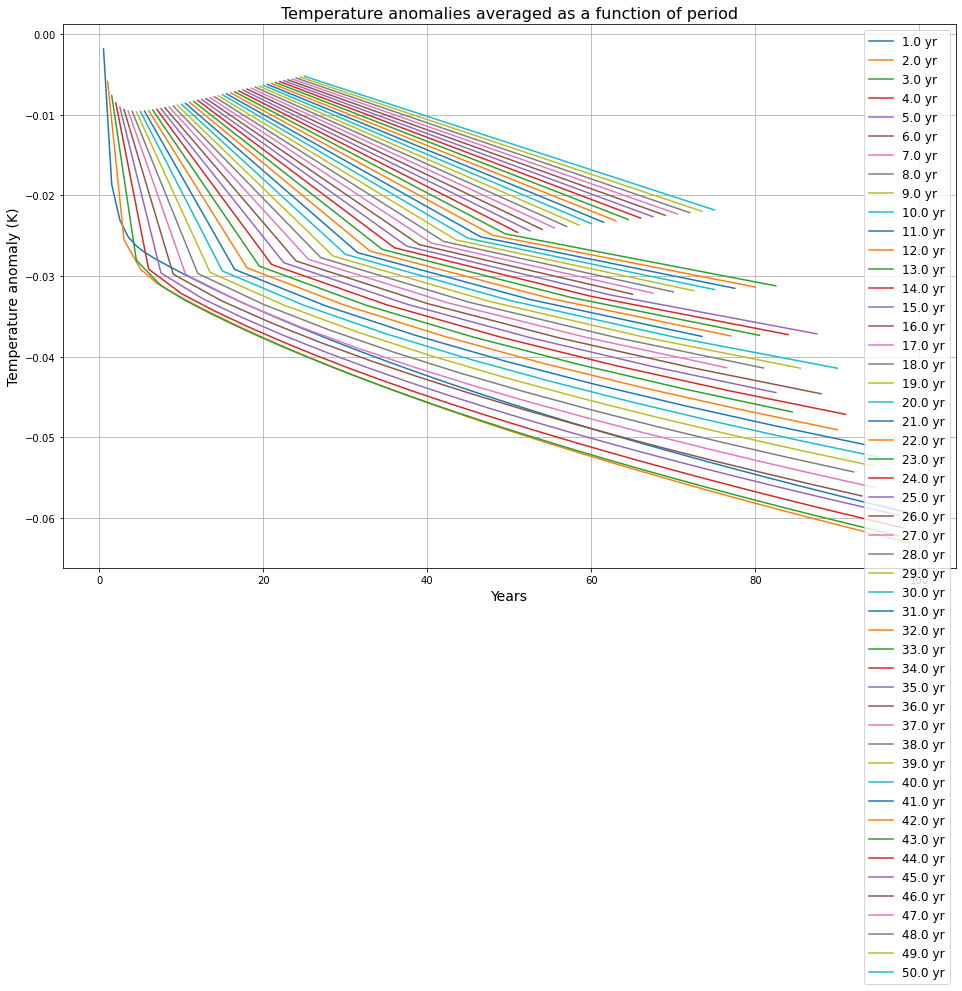

In [134]:
plt.figure(figsize=(16,10))

for i in range(len(periods)):
    plt.plot(time_aves[i]/36, T_aves[i], label=f'{periods[i]} yr')
    
plt.title('Temperature anomalies averaged as a function of period', fontsize=16)
plt.xlabel('Years', fontsize=14)
plt.xticks(fontsize=10)
plt.ylabel('Temperature anomaly (K)', fontsize=14)
plt.yticks(fontsize=10)
plt.grid()
plt.legend(fontsize=12)
# plt.savefig('sinusoids_anom_periodic_aves.jpg')

In [61]:
days = dt / 86400
timesteps = T_cont.shape[1]
length = (timesteps - 1) * days / 360
time_years = np.linspace(0, length, timesteps)

#Calculate ocean heat content (or global mean temperature)
temps = [T_cont,
         T_A1_P2,
        T_A1_P5,
        T_A1_P7,
        T_A1_P10,
        T_A1_P12,
        T_A1_P16,
        T_A1_P20]

OHCs = [OHC(temps[i]) for i in range(len(temps))]


OHCs_ave_over_period = [np.mean((OHCs[j] - OHCs[0])[periods[j] * i * 36 : P * (i + 1) * 36]) for i in range(len()) for j in range(1, len(periods[j]))]

TypeError: len() takes exactly one argument (0 given)

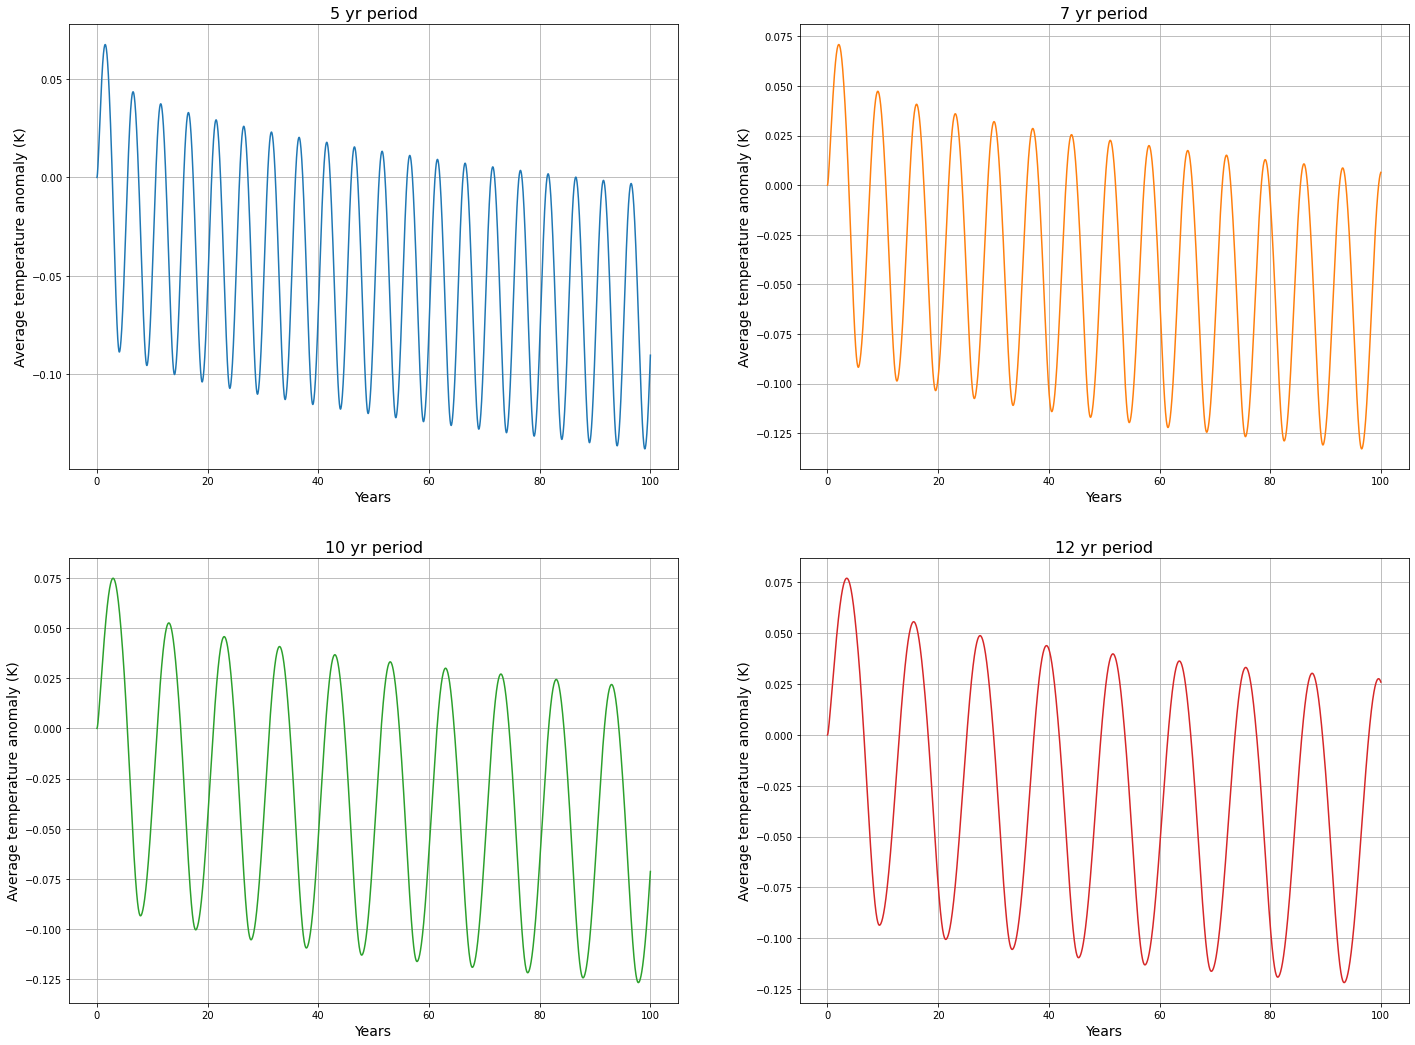

In [27]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(24, 18))
OHCs = [OHC_A1_P2, OHC_A1_P5, OHC_A1_P7, OHC_A1_P10, OHC_A1_P12, OHC_A1_P16, OHC_A1_P20]
names = ['2 yr period', '5 yr period', '7 yr period', '10 yr period', '12 yr period', \
         '16 yr period', '20 yr period']
colors = ['C0', 'C1', 'C2', 'C3']

for i, ax in enumerate(axs.flatten()):
    j = i + 1
    ax.plot(time_years, OHCs[j] - OHC_cont, color = colors[i])
    ax.set_title(names[j], fontsize=16)
    ax.set_xlabel('Years', fontsize=14)
    ax.set_ylabel('Average temperature anomaly (K)', fontsize=14)
    ax.grid()

In [281]:
# Calculate linear trend

def line(t, a, b):
    return a * t + b

days_in_year = 360

popt, pcov = curve_fit(line, t, OHC_A1_P2 - OHC_cont)
OHC_A1_P2_trend = line(t, *popt)
m2 = popt[0]

print(f'Temperature trend for sinusoidal forcing with 2 year period over 160 years is {round(m2 * days_in_year * 1e3, 2)} mK/year')
print(f'Net temperature drift for sinusoidal forcing with 2 year period over 160 years is {round(m2 * days_in_year * years, 2)} K')
print('')

popt, pcov = curve_fit(line, t, OHC_A1_P5 - OHC_cont)
OHC_A1_P5_trend = line(t, *popt)
m5 = popt[0]
print(f'Temperature trend for sinusoidal forcing with 5 year period over 160 years is {round(m5 * days_in_year * 1e3, 2)} mK/year')
print(f'Net temperature drift for sinusoidal forcing with 5 year period over 160 years is {round(m5 * days_in_year * years, 2)} K')
print('')

popt, pcov = curve_fit(line, t, OHC_A1_P20 - OHC_cont)
OHC_A1_P20_trend = line(t, *popt)
m20 = popt[0]
print(f'Temperature trend for sinusoidal forcing with 20 year period over 160 years is {round(m20 * days_in_year * 1e3, 2)} mK/year')
print(f'Net temperature drift for sinusoidal forcing with 20 year period over 160 years is {round(m20 * days_in_year * years, 2)} K')
print('')

popt, pcov = curve_fit(line, t, OHC_A1_P40 - OHC_cont)
OHC_A1_P40_trend = line(t, *popt)
m40 = popt[0]
print(f'Temperature trend for sinusoidal forcing with 40 year period over 160 years is {round(m40 * days_in_year * 1e3, 2)} mK/year')
print(f'Net temperature drift for sinusoidal forcing with 40 year period over 160 years is {round(m40 * days_in_year * years, 2)} K')
print('')

Temperature trend for sinusoidal forcing with 2 year period over 160 years is -0.15 mK/year
Net temperature drift for sinusoidal forcing with 2 year period over 160 years is -0.02 K

Temperature trend for sinusoidal forcing with 5 year period over 160 years is -0.21 mK/year
Net temperature drift for sinusoidal forcing with 5 year period over 160 years is -0.03 K

Temperature trend for sinusoidal forcing with 20 year period over 160 years is -0.33 mK/year
Net temperature drift for sinusoidal forcing with 20 year period over 160 years is -0.05 K

Temperature trend for sinusoidal forcing with 40 year period over 160 years is -0.44 mK/year
Net temperature drift for sinusoidal forcing with 40 year period over 160 years is -0.07 K



In [ ]:
#Plot

#fig = plt.figure(figsize=(18,8))
# plt.plot(time_years, OHC_A1_P2 - OHC_cont, label='2 yr', color = 'b')
# plt.plot(time_years, OHC_A1_P5 - OHC_cont, label='5 yr', color = 'r')
# plt.plot(time_years, OHC_A1_P20 - OHC_cont, label='20 yr', color = 'g')
# plt.plot(time_years, OHC_A1_P40 - OHC_cont, label='40 yr', color = 'k')
# plt.plot(time_years, OHC_A1_P2_trend, label='2 yr', color = 'purple', linestyle = ':')
# plt.plot(time_years, OHC_A1_P5_trend, label='5 yr', color = 'brown', linestyle = ':')
# plt.plot(time_years, OHC_A1_P20_trend, label='20 yr', color = 'pink', linestyle = ':')
# plt.plot(time_years, OHC_A1_P40_trend, label='40 yr', color = 'gray', linestyle = ':')
# plt.xlabel('Years', fontsize=12)
# plt.ylabel('Temperature anomaly (K)', fontsize=12)
# plt.title('Average temperature anomaly')
# plt.grid()
# plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1, 0.5),loc = 'center left')

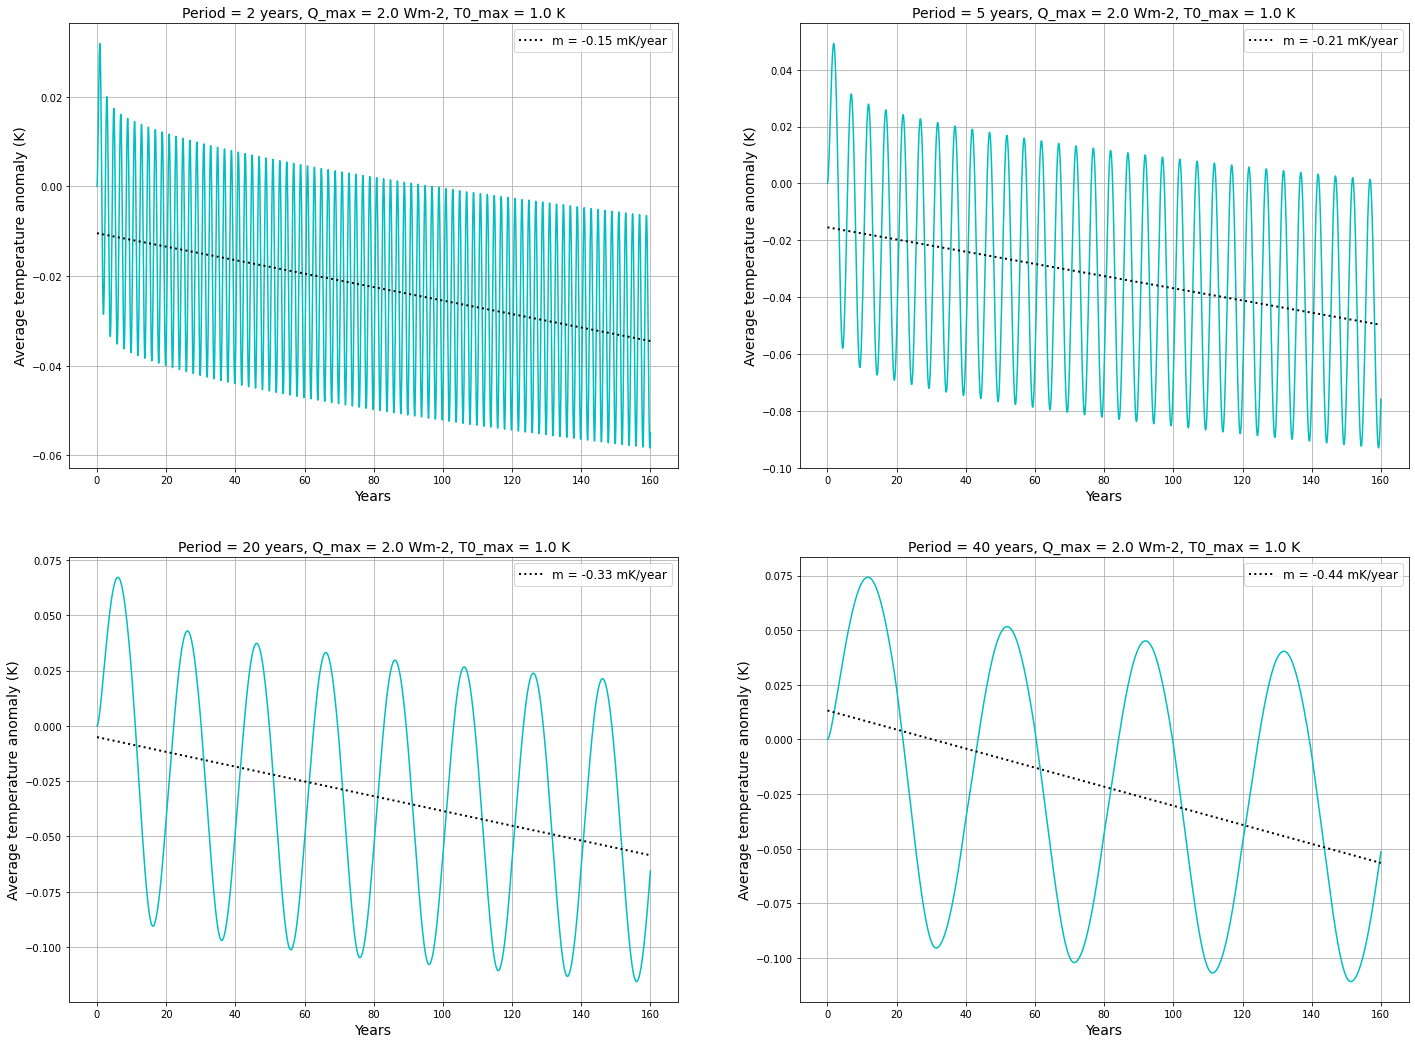

In [253]:
### Plot

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(24, 18))
axs[0, 0].plot(time_years, OHC_A1_P2 - OHC_cont, color = 'c')
axs[0, 0].plot(time_years, OHC_A1_P2_trend, label=f'm = {round(m2 * days_in_year * 1e3, 2)} mK/year', color = 'k', linestyle = ':', linewidth = 2.0)
axs[0, 0].set_xlabel('Years', fontsize=14)
axs[0, 0].set_ylabel('Average temperature anomaly (K)', fontsize=14)
axs[0, 0].set_title('Period = 2 years, Q_max = 2.0 Wm-2, T0_max = 1.0 K', fontsize=14)
axs[0, 0].grid()
axs[0, 0].legend(fontsize=12)

axs[0, 1].plot(time_years, OHC_A1_P5 - OHC_cont, color = 'c')
axs[0, 1].plot(time_years, OHC_A1_P5_trend, label=f'm = {round(m5 * days_in_year * 1e3, 2)} mK/year', color = 'k', linestyle = ':', linewidth = 2.0)
axs[0, 1].set_xlabel('Years', fontsize=14)
axs[0, 1].set_ylabel('Average temperature anomaly (K)', fontsize=14)
axs[0, 1].set_title('Period = 5 years, Q_max = 2.0 Wm-2, T0_max = 1.0 K', fontsize=14)
axs[0, 1].grid()
axs[0, 1].legend(fontsize=12)

axs[1, 0].plot(time_years, OHC_A1_P20 - OHC_cont, color = 'c')
axs[1, 0].plot(time_years, OHC_A1_P20_trend, label=f'm = {round(m20 * days_in_year * 1e3, 2)} mK/year', color = 'k', linestyle = ':', linewidth = 2.0)
axs[1, 0].set_xlabel('Years', fontsize=14)
axs[1, 0].set_ylabel('Average temperature anomaly (K)', fontsize=14)
axs[1, 0].set_title('Period = 20 years, Q_max = 2.0 Wm-2, T0_max = 1.0 K', fontsize=14)
axs[1, 0].grid()
axs[1, 0].legend(fontsize=12)

axs[1, 1].plot(time_years, OHC_A1_P40 - OHC_cont, color = 'c')
axs[1, 1].plot(time_years, OHC_A1_P40_trend, label=f'm = {round(m40 * days_in_year * 1e3, 2)} mK/year', color = 'k', linestyle = ':', linewidth = 2.0)
axs[1, 1].set_xlabel('Years', fontsize=14)
axs[1, 1].set_ylabel('Average temperature anomaly (K)', fontsize=14)
axs[1, 1].set_title('Period = 40 years, Q_max = 2.0 Wm-2, T0_max = 1.0 K', fontsize=14)
axs[1, 1].grid()
axs[1, 1].legend(fontsize=12)
plt.savefig('sinusoidal_diff_frequencies.jpg')

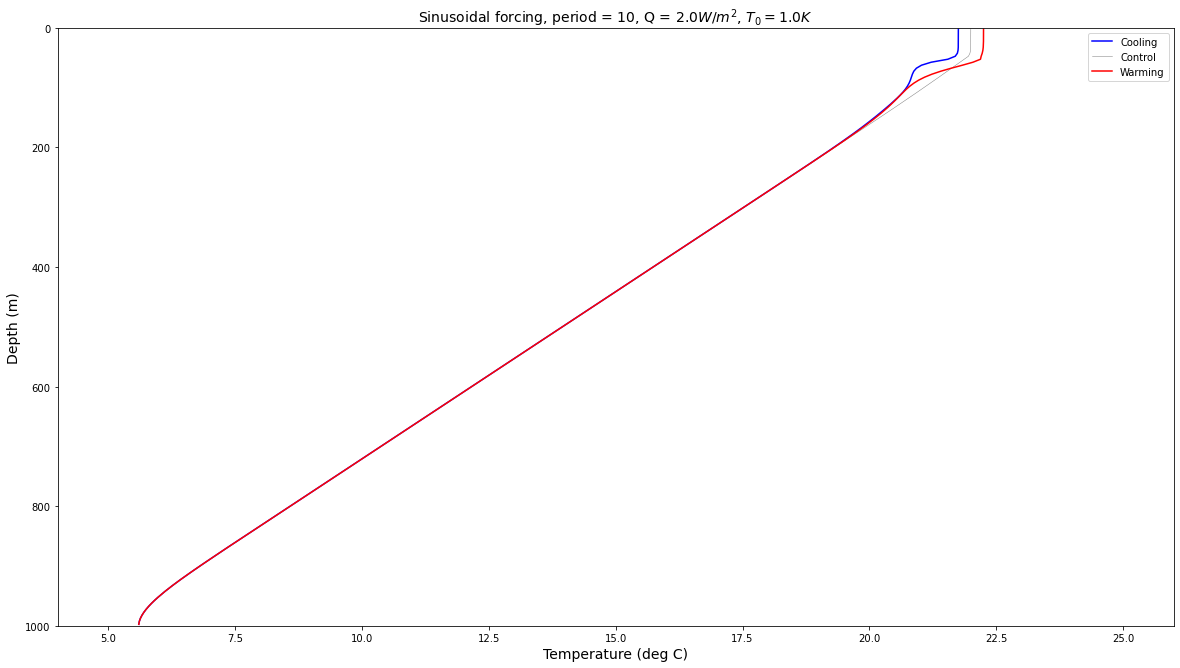

In [99]:
### Animate

### Eventually I would like a counter that reads how many years & days we are at: e.g., Year 0, day 10; Year 0, day 20, ...; Year 0 day 360; Year 1 day 10  

fig = plt.figure(figsize=(20, 11))
ax = plt.axes(xlim=(4, 26), ylim=(z[0], z[-1]))
line1, = ax.plot([], [], color = 'b', label = 'Cooling')
# line2, = ax.plot([], [], color = 'gray', label = 'Control', linewidth = 0.5)
# line3, = ax.plot([], [], color = 'r', label = 'Warming')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line1.set_data(cw_expt[:, i], z_t)
    #line2.set_data(control_expt[:, i], z_t)
    #line3.set_data(wc_expt[:, i], z_t)
    return line1,# line2, line3

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(warm[0, :]), interval=50, blit=True)

title = 'Sinusoidal forcing, period = 20 yr, Q = $2.0$ W$/m^2$, $T_0 = 1.0$ C'

ax.set_title(title, fontsize = 14)
ax.set_xlabel('Temperature (deg C)', fontsize = 14)
ax.set_ylabel('Depth (m)', fontsize = 14)
ax.invert_yaxis()
ax.legend()

anim.save('sinusoidal_period20.mp4')

### Seasonality and resonance

In [4]:
years = 100
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-06
mu = 1/(10 * 365 * 86400)

period = 1
Q_season_SH = 2.0 * np.sin((2 * np.pi / (period * 360)) * (t - 360/2))
T0_season_SH = 0.25 * np.sin((2 * np.pi / (period * 360)) * (t - 360/2))
Q_season_NH = 2.0 * np.sin((2 * np.pi / (period * 360)) * t)
T0_season_NH = 0.25 * np.sin((2 * np.pi / (period * 360)) * t)

control_with_seasonal_NH = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_season_NH, T0_season_NH, years)
control_with_seasonal_SH = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_season_SH, T0_season_SH, years)

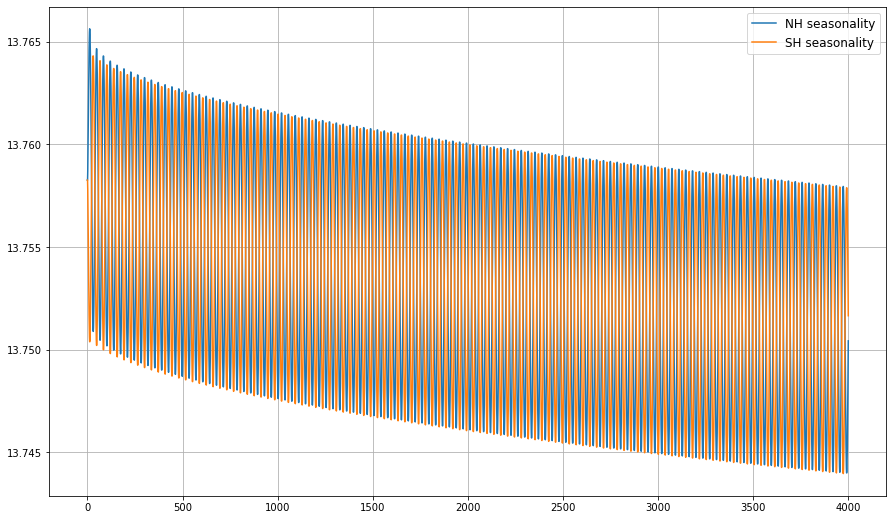

In [144]:
plt.figure(figsize=(15,9))
plt.plot(OHC(control_with_seasonal_NH)[:4000],label='NH seasonality')
plt.plot(OHC(control_with_seasonal_SH)[:4000],label='SH seasonality')
plt.grid()
plt.legend(fontsize=12)

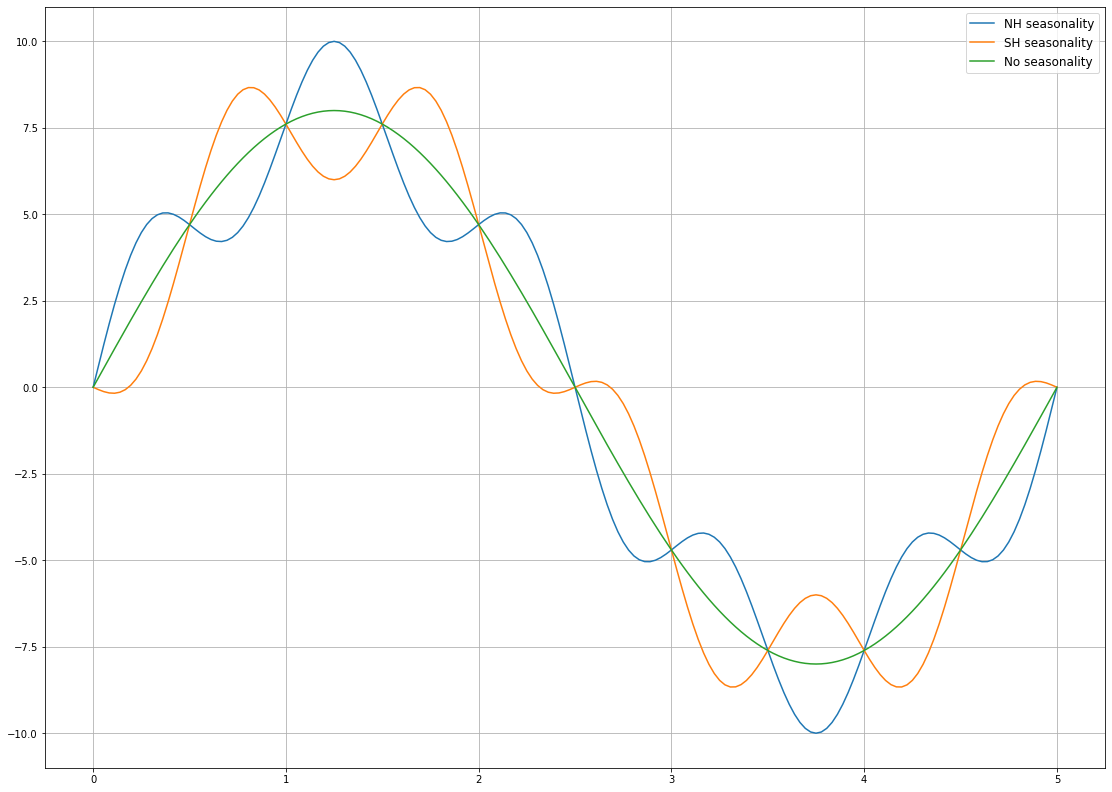

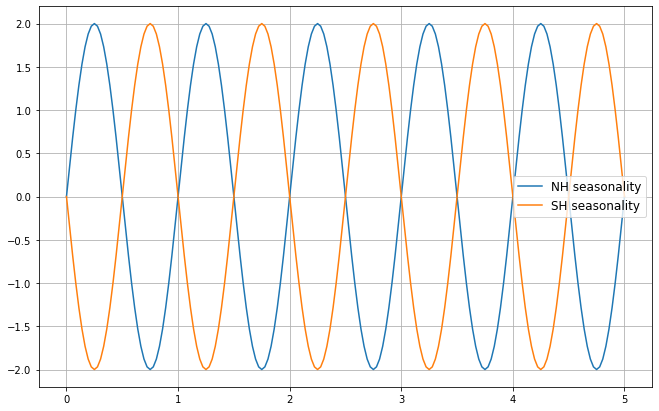

In [163]:
plt.figure(figsize=(19,14))
year = 5
plt.plot((t/360)[:year*36+1], (sin(8.0, 5)+Q_season_NH[:N+1])[:year*36+1],label='NH seasonality')
plt.plot((t/360)[:year*36+1], (sin(8.0, 5)+Q_season_SH[:N+1])[:year*36+1],label='SH seasonality')
plt.plot((t/360)[:year*36+1], sin(8.0, 5)[:year*36+1],label='No seasonality')
plt.legend()
plt.grid()
plt.legend(fontsize=12)

plt.figure(figsize=(11,7))
plt.plot((t/360)[:year*36+1], (Q_season_NH[:N+1])[:year*36+1],label='NH seasonality')
plt.plot((t/360)[:year*36+1], (Q_season_SH[:N+1])[:year*36+1],label='SH seasonality')
plt.legend()
plt.grid()
plt.legend(fontsize=12)

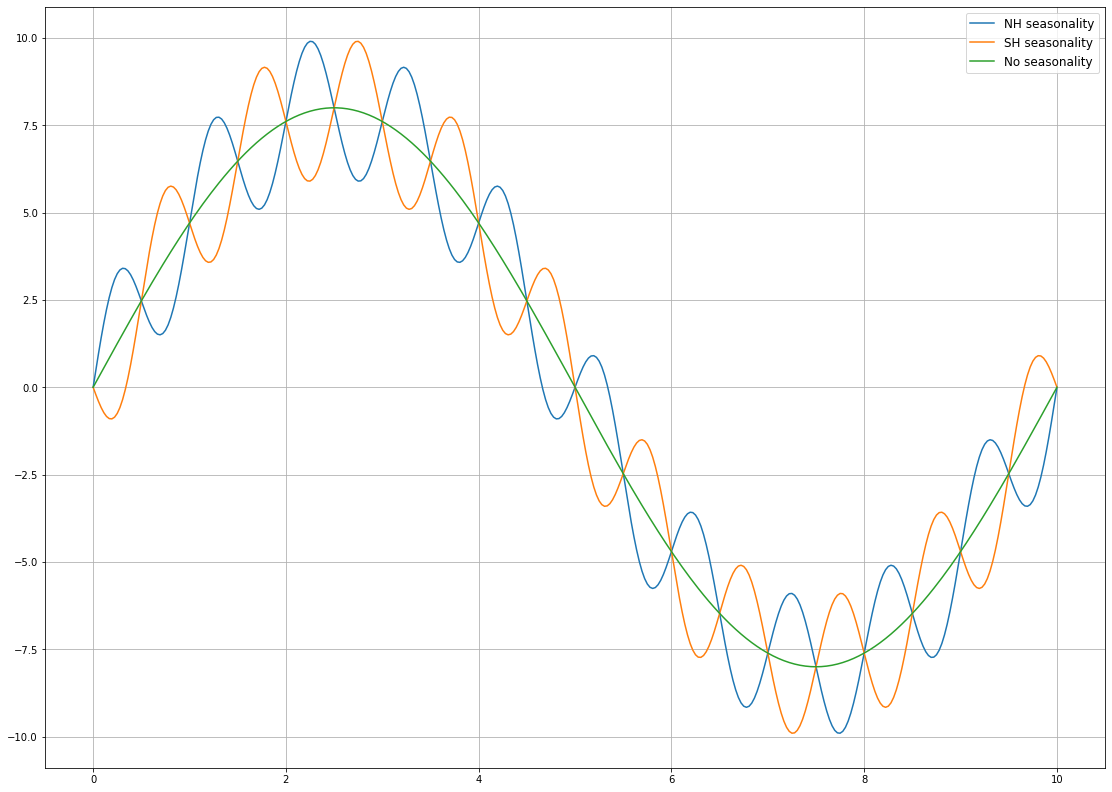

In [172]:
plt.figure(figsize=(19,14))
year = 10
Q_season_NH_10 = 2.0 * np.sin((2 * np.pi / (1 * 360)) * t)
Q_season_SH_10 = 2.0 * np.sin((2 * np.pi / (1 * 360)) * (t - 360/2))
Q_10 = sin(8.0, 10) # 8.0*np.sign(sin(8.0, 10))
plt.plot((t/360)[:year*36+1], (Q_10+Q_season_NH_10)[:year*36+1],label='NH seasonality')
plt.plot((t/360)[:year*36+1], (Q_10+Q_season_SH_10)[:year*36+1],label='SH seasonality')
plt.plot((t/360)[:year*36+1], Q_10[:year*36+1],label='No seasonality')
plt.legend()
plt.grid()
plt.legend(fontsize=12)

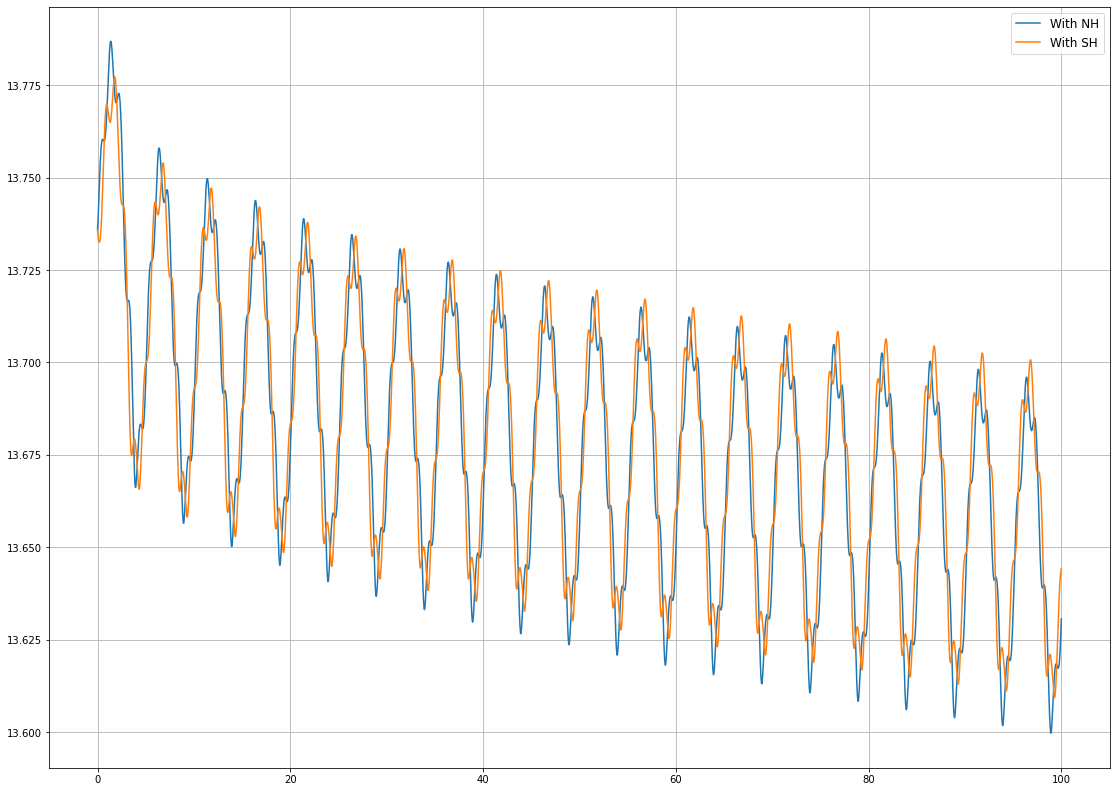

In [159]:
plt.figure(figsize=(19,14))
plt.plot(t/360, OHC(T_period5_with_season_NH) - OHC(T_period5_with_season_NH)[0] + (OHC(T_period5_with_season_NH)[0] + OHC(T_period5_with_season_SH)[0])/2,label='With NH')
plt.plot(t/360, OHC(T_period5_with_season_SH) - OHC(T_period5_with_season_SH)[0] + (OHC(T_period5_with_season_NH)[0] + OHC(T_period5_with_season_SH)[0])/2,label='With SH')
plt.grid()
plt.legend(fontsize=12)

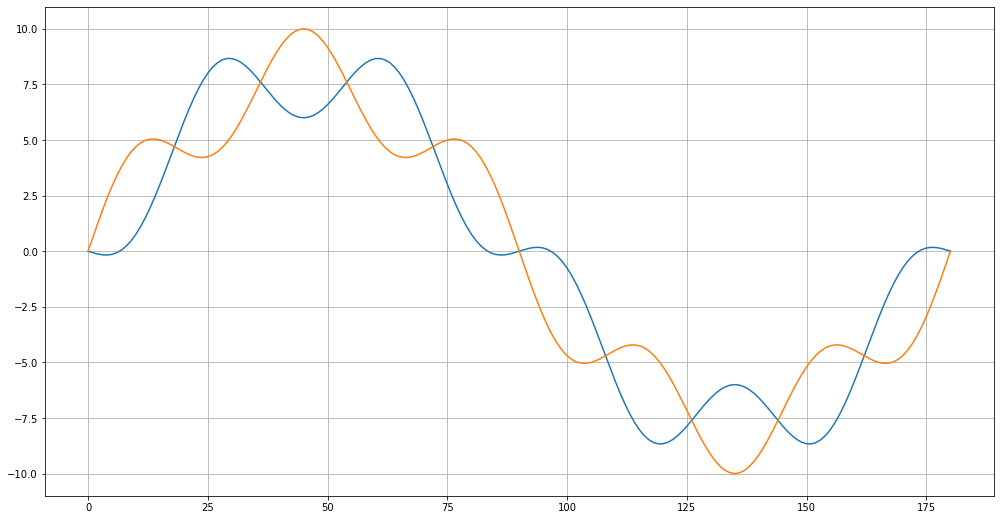

In [86]:
plt.figure(figsize=(17,9))
# plt.plot(Q_season_SH[:5*36+1])
plt.plot((Q_season_SH+sin(8, 5))[:5*36+1])
plt.plot((Q_season_NH+sin(8, 5))[:5*36+1])
plt.grid()